# First, we load some packages that will be useful

In [1]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [2]:
# Set up the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = "cpu"
print(device)

cuda:0


# Load the data and plot it

In [3]:
train_batch_size = 16
test_batch_size  = 100

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=train_batch_size,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


truck  ship plane   car  bird   cat  bird  ship  frog   car  bird  ship  ship  frog truck horse


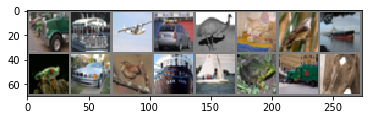

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(train_batch_size)))


# Define loss function

In [5]:
lossFunc = nn.CrossEntropyLoss()
def misfit(X,W,C):
    n = W.shape
    X = X.view(-1,n[0])
    S = torch.matmul(X,W)
    return lossFunc(S,C), S   

def getAccuracy(S,labels):
    _, predicted = torch.max(S.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct/total

# Define tv norm to scale the data and other utilities

In [6]:
def tvnorm(X):
    n = X.shape
    eps = 1e-4
    absx = torch.sqrt(torch.mean(X**2,dim=1) + eps)
    Y = X.clone()
    for i in range(X.shape[1]):
        Y[:,i,:,:] = Y[:,i,:,:]/absx

    return Y

def conv3x3(x,K):
    """3x3 convolution with padding"""
    return F.conv2d(x, K, stride=1, padding=1)

In [7]:
class simpleConvNet(nn.Module):

    def __init__(self, NG,c):
        super().__init__()

        # network geometry
        self.NG       = NG        
        self.coarsen  = c

    def forward(self,x,K):
    
        z  = conv3x3(x,K)
        y  = F.relu(z)
        w  = y.clone()
        for i in range(c):
            w = F.avg_pool2d(w,3,stride=2,padding=1)
             
        return w
        
   

In [8]:
# initialize net and weights
nClass   = 10
nchanIn  = 3
nchanOut = 64

# Network geometry
NG = [nchanIn,    nchanOut]
# coarsening parameter
c = 3

net   = simpleConvNet(NG,c)
net.to(device)

K = nn.Parameter(torch.randn(NG[1], NG[0] ,3,3))
K.data = K.data.to(device)

# weights for linear classifier    
npixOut = 32//2**c
W     = nn.Parameter(torch.randn(nchanOut*npixOut*npixOut,nClass)*1e-3)
W.data = W.data.to(device)

# count parameters
npars = np.prod(W.shape) + np.prod(K.shape)
print("Number of linear parameters ", np.prod(W.shape))
print("Number of nonlinear parameters ", np.prod(K.shape))

print("Total number of parameters ", npars)


Number of linear parameters  10240
Number of nonlinear parameters  1728
Total number of parameters  11968


In [9]:
# test the nestwork
images, labels = dataiter.next()
images, labels = images.to(device), labels.to(device)

x = net(images,K)

C = torch.randint(0,10,(train_batch_size,),dtype=torch.long)
C = C.to(device)

loss,_ = misfit(x,W,C)
print(loss)  
print(np.log(10))

tensor(2.3034, device='cuda:0')
2.302585092994046


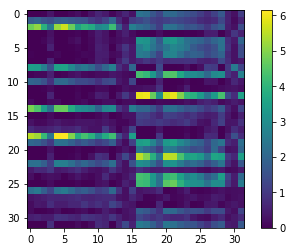

In [10]:
# Plot the output
x1 = x[0,:,:,:].cpu().detach().numpy()
x1 = x1.reshape(8*4,8*4)
im = plt.imshow(x1)
plt.colorbar(im)
   

In [11]:
# test the grdient
loss.backward()

In [12]:
import torch.optim as optim
optimizer = optim.SGD([{'params':K},{'params': W}], lr=1e-2, momentum=0.9)


In [13]:
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x    = net(inputs,K)
        loss, Si = misfit(x,W,labels)
        loss.backward()
             
        optimizer.step()

        # print statistics
        accuracy = getAccuracy(Si,labels)
        running_loss     += loss.item()
        running_accuracy += accuracy
        if i % 200 == 199:    # print every 200 mini-batches
            # compute validation accuracy
            with torch.no_grad():
                #for data in testloader:
                dataiter = iter(testloader)
                imagesV, labelsV = dataiter.next()
                imagesV, labelsV = imagesV.to(device), labelsV.to(device)
                xV = net(imagesV,K)
                lossV, SiV = misfit(xV,W,labelsV)
                accuracyV  = getAccuracy(SiV,labelsV)

            
            print('[%d, %5d]  %.3f  %.3f  %.3f' %
                  (epoch + 1, i + 1, running_loss / 200, running_accuracy/200, accuracyV))
            running_loss = 0.0
            running_accuracy = 0.0

print('Finished Training')

[1,   200]  3.626  0.267  0.410
[1,   400]  1.900  0.377  0.360
[1,   600]  1.765  0.414  0.440
[1,   800]  1.670  0.431  0.580
[1,  1000]  1.619  0.439  0.570
[1,  1200]  1.559  0.456  0.470
[1,  1400]  1.544  0.464  0.580
[1,  1600]  1.526  0.472  0.550
[1,  1800]  1.490  0.480  0.450
[1,  2000]  1.438  0.493  0.580
[1,  2200]  1.432  0.503  0.550
[1,  2400]  1.454  0.493  0.460
[1,  2600]  1.445  0.492  0.630
[1,  2800]  1.440  0.503  0.500
[1,  3000]  1.376  0.520  0.540
[2,   200]  1.381  0.528  0.620
[2,   400]  1.321  0.543  0.600
[2,   600]  1.351  0.525  0.560
[2,   800]  1.350  0.523  0.640
[2,  1000]  1.329  0.539  0.610
[2,  1200]  1.354  0.519  0.470
[2,  1400]  1.315  0.540  0.640
[2,  1600]  1.311  0.541  0.620
[2,  1800]  1.272  0.549  0.650
[2,  2000]  1.321  0.530  0.590
[2,  2200]  1.323  0.532  0.580
[2,  2400]  1.283  0.552  0.590
[2,  2600]  1.264  0.567  0.670
[2,  2800]  1.309  0.553  0.680
[2,  3000]  1.294  0.549  0.600
[3,   200]  1.277  0.554  0.590
[3,   40

KeyboardInterrupt: 

In [13]:
NG.shape

(3, 7)